## Train Destination Arrival Time Prediction With XGboost

Goal:

Analyze the attached dataset to determine patterns in travel times with the goal of developing a regressor to predict time of arrival at the destination from the current location.

Dataset: problem_dataset.csv <br>
- Tripuid – unique identifier for the trip<br>
- origin_location – Station where the car originated from.<br>
- destination_location – final destination of the trip<br>
- sighting _location – location where car was sighted at the date time in the location_arrival_date field.<br>
- Sighting_location_lat – latitude of the sighting location<br>
- Sighting_location_lon – longitude of the sighting location<br>
- Location_arrival_date – date time the car arrived at the sighting_location<br>
- Location_departure_date – date time the car left the sighting location<br>
- Origin_departure_date – date time the car departed from the origin<br>
- Train_arrival_date – date time the car arrived at the trip’s final destination.<br>

This data set is made up of multiple time series with different length timeperiods. Some trips having over 40 points and other less than 25 hence a traditional forecast algorithm may not be the best choice here. XGboost is a general good performimg algorithm and is used widely used as first choice algorithm, since it can handle non linear data and is robust to many conditions, such as outliers, can handle categorical features in some situations (however not applicable here).

Steps<br>
1. Feature engineering
2. Exploratory Data Analysis
3. Hyperparameter optimization
4. Model training with 5-fold Cross validation
5. Model Performance
6. Results interpretation

## Step1 Feature engineering

Here we access the data types with df.info() there are 4 features as pandas Datastamps we can use this information to extract the **day of week, month and hour of day** to add to the features in the dataset. There may be trends that occur during the hours of the such as : <br>

Case1: When a train reaches a location in early hours of the day it generally has overall lower arrival times.<br>
Case2: certain days of the week the overall arrival times may be higher due an activity or other things that cause a delay on that day of week.<br>
Case3:certain months or season of the year due to weather may have higher or lower arrival times.<br>

The day of week and month were one hot encoded adding a total of 19 features. The sight location feature was also one hot encoded this created an additional 46 columns. The location where the train made a stop may influence the arrival time, however the model cannot recognise categorical features as categories if they are label encoded, hence they need to be binary form (one hot encoding). The draw back is a much larger data set however we want to ensure that the model is learning information properly.

Another set of features generated are the **timedeltas** these specify time between destinations. Two were created and listed below. The haversine distance was determined between sighting locations.

During feature generation the latency of the arrival time predictions are important. For example if the arrival times need to be calculated before the trip starts for new predictions : features such as Location_arrival_date, non-zero difference in the location_arrival_date and location_departure_date will not be known and cannot be imputed which will lower model performance ability. In this study these are known and imputed. However as the train logs these information as the trip commmences the more features the model will have for arrival prediction.


**Features Generated from feature engineering include:**
1. month (12): month trip occured (from one hot encoding)
2. day_of_week(7): Day in the week trip occured (from one hot encoding)
3. hour: hour of day feature occured
4. timedelta1: time between origin_departure_date and train_arrival_date (minutes)
5. timedelta3: time between location_departure_date and location_arrival_date in (minutes)
6. haversine: this is the haversine disatnce between 2 locations
7. sighting_location (46): from sighting_location (from one hot encoding)

**Target Variable**<br>
The target in this study is the overall time between origin_departure_date and train_arrival_date in minutes which is **timedelta1**


In [2]:
#pip install haversine

In [3]:
import pandas as pd
from haversine import haversine, Unit
import datetime
from datetime import datetime
from sklearn import preprocessing
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from math import sqrt
import shap 
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('Copy of clm_data.xlsx')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tripuid                  1610 non-null   object        
 1   origin_location          1610 non-null   object        
 2   destination_location     1610 non-null   object        
 3   sighting_location        1610 non-null   object        
 4   sighting_location_lat    1610 non-null   float64       
 5   sighting_location_lon    1610 non-null   float64       
 6   location_arrival_date    1610 non-null   datetime64[ns]
 7   location_departure_date  1610 non-null   datetime64[ns]
 8   origin_departure_date    1610 non-null   datetime64[ns]
 9   train_arrival_date       1610 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(2), object(4)
memory usage: 125.9+ KB


In [6]:
df.head(5)

,tripuid,origin_location,destination_location,sighting_location,sighting_location_lat,sighting_location_lon,location_arrival_date,location_departure_date,origin_departure_date,train_arrival_date
0,10054656400104001315859000566790000,"STEHEIGHT, MI","VOLTZ, MO","STERLING HEIGHTS, MI",42.537908,-83.037650,2021-04-30 19:28:00,2021-04-30 19:28:00.000000,2021-04-30 19:28:00,2021-05-03 12:21:00
1,10054656400104001315859000566790000,"STEHEIGHT, MI","VOLTZ, MO","WARREN, MI",42.499210,-83.037413,2021-04-30 21:45:00,2021-04-30 21:46:00.000000,2021-04-30 19:28:00,2021-05-03 12:21:00
2,10054656400104001315859000566790000,"STEHEIGHT, MI","VOLTZ, MO","DETROIT STERLING, MI",42.572998,-83.040002,2021-05-01 00:00:00,2021-05-01 12:30:00.000001,2021-04-30 19:28:00,2021-05-03 12:21:00
3,10054656400104001315859000566790000,"STEHEIGHT, MI","VOLTZ, MO","DETROIT NORTH YARD, MI",42.406106,-83.037049,2021-05-01 13:30:00,2021-05-01 15:30:00.000001,2021-04-30 19:28:00,2021-05-03 12:21:00
4,10054656400104001315859000566790000,"STEHEIGHT, MI","VOLTZ, MO","OAKWOOD, MI",42.278053,-83.170834,2021-05-01 18:17:00,2021-05-01 18:17:00.000000,2021-04-30 19:28:00,2021-05-03 12:21:00


In [7]:
import numpy as np
import datetime

### Feature creation

In [8]:
# month, day of week, hour of day generation

df['month'] = df.location_arrival_date.apply(lambda x: x.month_name())
df['hour'] = df.location_arrival_date.apply(lambda x: x.hour)
df['day_of_week'] = df.location_arrival_date.apply(lambda x: x.day_name())
df['tra_odd'] = df['train_arrival_date'] - df['origin_departure_date']
df['s2_s1'] = df['location_departure_date'] - df['location_arrival_date']
df['timedelta1'] = df.tra_odd.apply(lambda x: x.total_seconds() / 120.0)
df['timedelta3'] = df.s2_s1.apply(lambda x: x.total_seconds() / 120.0)

In [9]:
# removing variables that are not accepatable in ml model
df = df.drop(['destination_location','origin_location','s2_s1','tra_odd'],axis=1) 

In [10]:
# generating haversine distance
def hav(b):
    a=[]
    for i in range(len(b)-1):
        c = b[i]
        d = b[i-1]
        f = haversine((c[0],c[1]),(d[0],d[1]))
        a.append(f)
    return a

In [11]:
hav_dist = list(zip(df['sighting_location_lat'],df['sighting_location_lon']))
haversine_dist= hav(hav_dist)

df['haverstine'] = pd.DataFrame(haversine_dist)

In [12]:
df2 = df[['month','hour','day_of_week','timedelta1','timedelta3','haverstine']] 

In [13]:
# one hot encoding certain features

dfohe = pd.get_dummies(df[['sighting_location','day_of_week','month']], prefix='')
df2 = pd.concat([df2, dfohe], axis=1)
df2.shape

(1610, 71)

In [14]:
dfohe.head()

,"_BEMENT, IL","_BIRMINGHAM, MO","_BOODY, IL","_BUFFALO SCANNER, IL","_CARPENTER SCANNER, IL","_CLAPPER, MO","_CLIFTON HILL, MO","_DECATUR, IL","_DELPHI, IN","_DELRAY, MI",...,_December,_February,_January,_July,_June,_March,_May,_November,_October,_September
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [15]:
df_plot = df2.iloc[1:,:]
df_plot = df2[df2['timedelta1'] != 8117.000000]
df_plot.head()

,month,hour,day_of_week,timedelta1,timedelta3,haverstine,"_BEMENT, IL","_BIRMINGHAM, MO","_BOODY, IL","_BUFFALO SCANNER, IL",...,_December,_February,_January,_July,_June,_March,_May,_November,_October,_September
0,April,19,Friday,1946.5,0.0,1026.914338,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,April,21,Friday,1946.5,0.5,4.303071,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,May,0,Saturday,1946.5,375.0,8.207604,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,May,13,Saturday,1946.5,60.0,18.559149,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,May,18,Saturday,1946.5,0.0,17.990208,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Step2 Exploratory Data Analysis

Here the data is analyzed to look for any patterns. PLOT 1: We look at the monthly bar chart seems that June and May have slightly higher (faster) average arrival times, while January and December have slightly lower arrival times, however further analysis can be done such as resampling the timeseries which could divide the series into partions by month and the various time series could be plotted to see which trips caused these overall outcome.

PLOT 2: looking at the arrival times for day of week there doesnt seem to be a pattern for any particular day. However this is a summary over all trips for further analysis, data can be resampled to weeks so that daily patterns can be accessed.

PLOT3: It is good practice to access general overview of the data visually this can be done with pairplot this shows us how every 2 variables are correlated with each other, as well as the distrubution. Timedelta3 and haversine distance has a skewed distribution, if a linear regression model were to be used a log or exponential can be used to make the distribution normal for better model performance. (This was not be applied here).

TABLE1: The pearson correlation were determined and none of the features are highly correlation with each other. Highly correlated features are generally discouraged however in tree based models it is robust to high correlation but linear regression, logistic regression, neural networks and GLM, are not robust to multicollinearity and should be avoided. 

PLOT 4: An outlier trip was located that could be seen in the arrival time line plot. It was found in the describe() table. This had a timedelta of 8117minutes where all other value for all other timedeltas are less than 3500minutes. This data tripuid (timeseries) was removed from the dataset for optimal model performance.

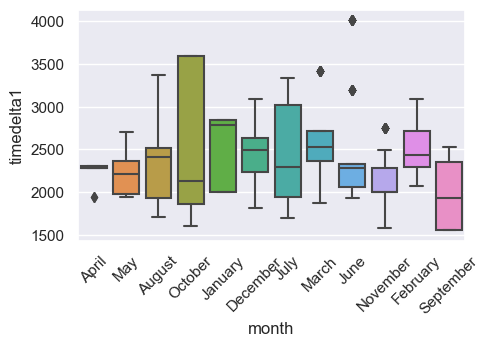

In [29]:
# PLOT 1

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (5,3))
ax = sns.boxplot(x="month", y="timedelta1", data=df_plot)
plt.xticks(rotation = 45)
plt.show()

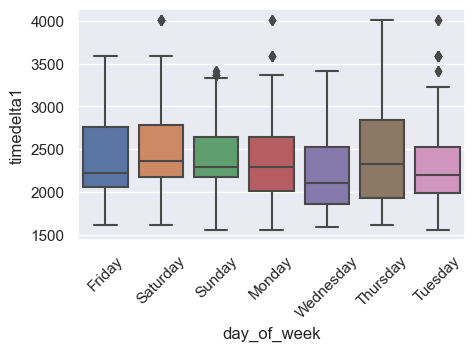

In [54]:
#PLOT 2

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (5,3))
ax = sns.boxplot(x="day_of_week", y="timedelta1", data=df_plot)
plt.xticks(rotation = 45)
plt.show()

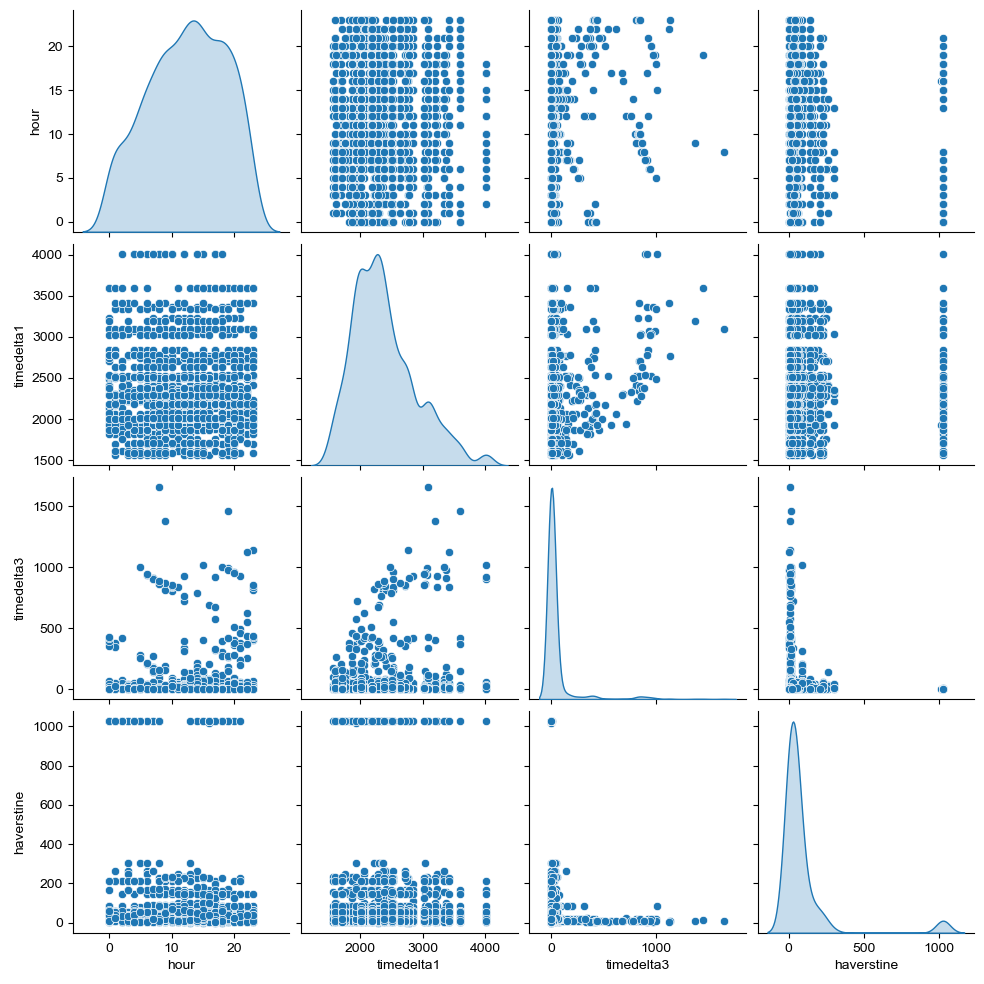

In [20]:
#PLOT 3

sns.pairplot(df_plot[['month','hour','day_of_week','timedelta1','timedelta3','haverstine']], diag_kind = "kde")#,'timedelta4''timedelta2',
sns.set(rc={'figure.figsize':(4,4)})
plt.show()

In [30]:
#TABLE 1 

d2 = df_plot[['month','hour','day_of_week','timedelta1','timedelta3','haverstine']]
d2.corr(method='pearson')

,hour,timedelta1,timedelta3,haverstine
hour,1.000000,0.007601,0.047268,-0.177611
timedelta1,0.007601,1.000000,0.146817,0.024636
timedelta3,0.047268,0.146817,1.000000,-0.100073
haverstine,-0.177611,0.024636,-0.100073,1.000000


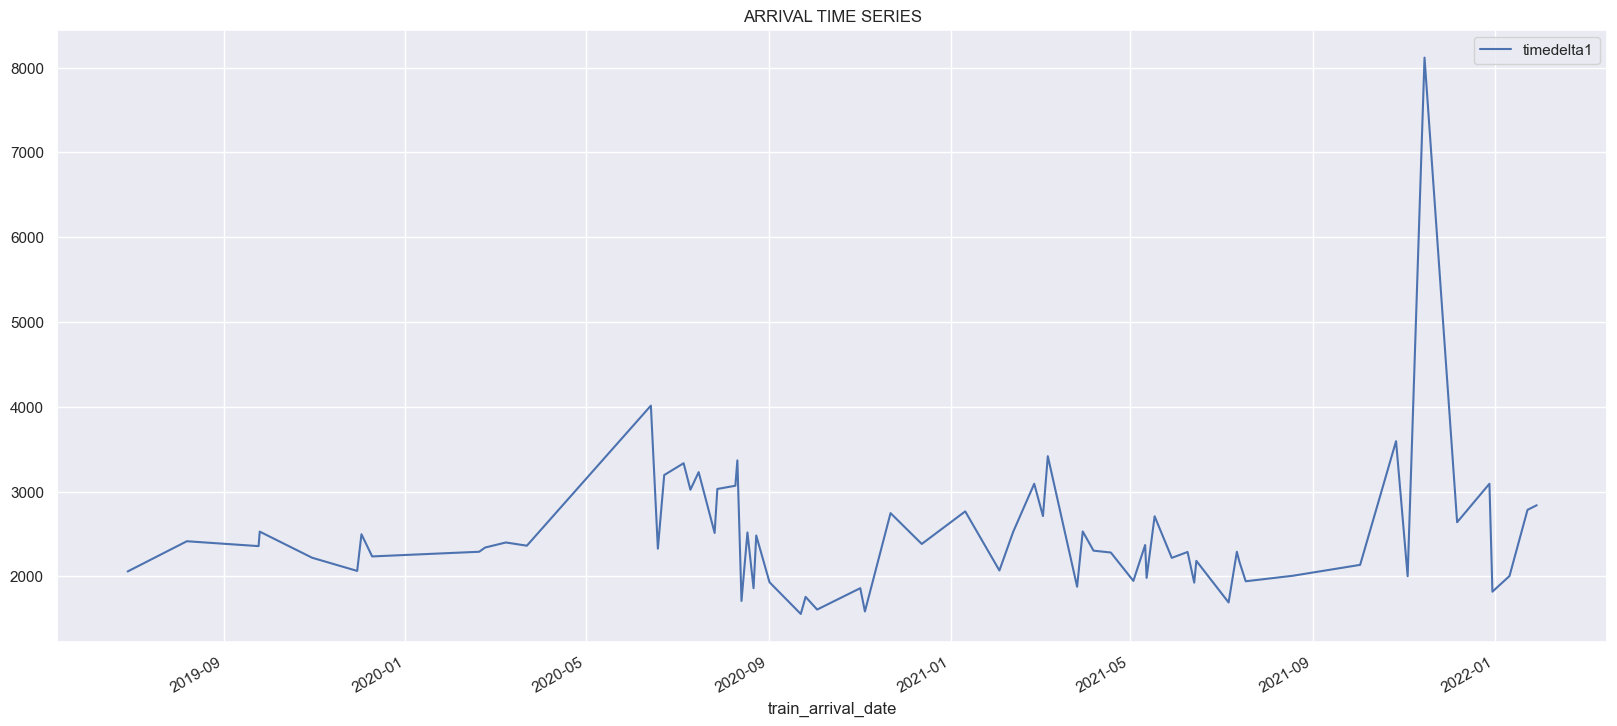

In [59]:
#PLOT 4

d3 = df[['train_arrival_date','timedelta1']]
d3 = d3.set_index('train_arrival_date',drop=True)
plt.rcParams["figure.figsize"] = (20,9)
d3.plot()
plt.title('ARRIVAL TIME SERIES')
plt.show()

## Test-train split

Here the data is filtered by tripuid before training spilt to ensure no parts of the test trip (being multiple rows per trip) is mixed with the training dataset as was advised in the documents. Here 25% of the data is used for test and 75% for training.

In [21]:
df2['tripuid'] = df['tripuid']

In [22]:
ids = df['tripuid'].unique()

from sklearn.model_selection import train_test_split
ids_train, ids_test = train_test_split(ids, test_size=0.25, random_state=42)

In [23]:
print(ids_train.shape)
print(ids_test.shape)

(50,)
(17,)


In [24]:
df2.head(3)

,month,hour,day_of_week,timedelta1,timedelta3,haverstine,"_BEMENT, IL","_BIRMINGHAM, MO","_BOODY, IL","_BUFFALO SCANNER, IL",...,_February,_January,_July,_June,_March,_May,_November,_October,_September,tripuid
0,April,19,Friday,1946.5,0.0,1026.914338,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10054656400104001315859000566790000
1,April,21,Friday,1946.5,0.5,4.303071,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10054656400104001315859000566790000
2,May,0,Saturday,1946.5,375.0,8.207604,0,0,0,0,...,0,0,0,0,0,1,0,0,0,10054656400104001315859000566790000


In [25]:
#filtering the data by tripuid.
new = df2["tripuid"].isin(ids_train)
  
train_df = df2[new]
test_df = df2[~new]
df3 = df2.iloc[1:,:]

X_train, y_train = df3.drop(['tripuid','timedelta1','day_of_week','month'],axis=1), df3['timedelta1']
X_test, y_test = df3.drop(['tripuid','timedelta1','day_of_week','month'],axis=1), df3['timedelta1']

In [27]:
df3.describe()

,hour,timedelta1,timedelta3,haverstine,"_BEMENT, IL","_BIRMINGHAM, MO","_BOODY, IL","_BUFFALO SCANNER, IL","_CARPENTER SCANNER, IL","_CLAPPER, MO",...,_December,_February,_January,_July,_June,_March,_May,_November,_October,_September
count,1609.000000,1609.000000,1609.000000,1608.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,...,1609.000000,1609.000000,1609.000000,1609.000000,1609.00000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000
mean,12.441268,2545.050342,47.357365,90.181175,0.001243,0.000622,0.001243,0.036669,0.001243,0.034804,...,0.103791,0.058421,0.079553,0.132380,0.10752,0.066501,0.100062,0.097576,0.070230,0.047856
std,6.206175,1080.023638,166.985466,202.179463,0.035245,0.024930,0.035245,0.188006,0.035245,0.183341,...,0.305084,0.234611,0.270683,0.339009,0.30987,0.249233,0.300176,0.296833,0.255614,0.213527
min,0.000000,1556.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,2004.000000,0.000000,10.816114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,2290.000000,0.000000,35.850825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,2710.500000,11.500000,66.898141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,23.000000,8117.000000,1656.500000,1027.067059,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
df3 = df2[df2['timedelta1'] != 8117.000000]

df3.shape

(1564, 72)

## Step3 Hyperparameter Optmization

Hyperparameters are certain values or weights that determine the learning process of an algorithm. The hyperparameter selected for tuning are:

- learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
- max_depth: determines how deeply each tree is allowed to grow during any boosting round
- colsample_bytree: percentage of features used per tree. High value can lead to overfitting
- n_estimators: number of trees you want to build.
- objective: determines the loss function to be used like reg:squarederror for regression problems

The best parameters are printed below:

In [29]:
y_train.shape

(1609,)

In [30]:
import xgboost as xgb
parameters = {'objective':['reg:squarederror'], 'colsample_bytree':[0.5,0.7],'learning_rate':[0.1,0.3,0.5], 
              'max_depth':[5,4,6], 'alpha':[10, 12], 'n_estimators':[50,100]}

xg_reg = XGBRegressor()

GridSearchCV(estimator = xg_reg,
             param_grid = parameters,
            cv=4,)

clf = GridSearchCV(xg_reg, parameters,scoring='neg_root_mean_squared_error')
clf.fit(X_train, y_train)
clf.best_params_

{'alpha': 10,
 'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 50,
 'objective': 'reg:squarederror'}

### hyperparameter search results
This is a summary of all for the specified hyperparameters (combinations checked (72))

In [31]:
pd.DataFrame.from_dict(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_objective,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.079482,0.005350,0.003161,0.000075,10,0.5,0.1,5,50,reg:squarederror,"{'alpha': 10, 'colsample_bytree': 0.5, 'learni...",-753.748867,-866.899606,-2288.796401,-1088.756034,-797.166038,-1159.073389,576.515227,2
1,0.148670,0.002306,0.003491,0.000168,10,0.5,0.1,5,100,reg:squarederror,"{'alpha': 10, 'colsample_bytree': 0.5, 'learni...",-767.852152,-956.836955,-2291.059718,-1270.839022,-822.447951,-1221.807159,562.401510,16
2,0.063536,0.001142,0.003098,0.000053,10,0.5,0.1,4,50,reg:squarederror,"{'alpha': 10, 'colsample_bytree': 0.5, 'learni...",-738.310194,-862.851162,-2292.277723,-1117.556775,-785.885318,-1159.376234,581.366295,4
3,0.129821,0.018602,0.003262,0.000140,10,0.5,0.1,4,100,reg:squarederror,"{'alpha': 10, 'colsample_bytree': 0.5, 'learni...",-753.539128,-933.094098,-2293.905773,-1284.398803,-823.384768,-1217.664514,568.260139,13
4,0.090747,0.000718,0.003148,0.000033,10,0.5,0.1,6,50,reg:squarederror,"{'alpha': 10, 'colsample_bytree': 0.5, 'learni...",-757.670540,-865.972612,-2287.768622,-1082.843329,-801.081543,-1159.067329,575.318073,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.188267,0.008335,0.003375,0.000096,12,0.7,0.5,5,100,reg:squarederror,"{'alpha': 12, 'colsample_bytree': 0.7, 'learni...",-843.112295,-1075.606442,-2274.542040,-1342.931062,-979.880423,-1303.214452,512.464435,67
68,0.076167,0.000960,0.003081,0.000073,12,0.7,0.5,4,50,reg:squarederror,"{'alpha': 12, 'colsample_bytree': 0.7, 'learni...",-783.160206,-1071.805660,-2310.621467,-1232.530226,-883.405411,-1256.304594,549.383028,41
69,0.148049,0.002156,0.003247,0.000074,12,0.7,0.5,4,100,reg:squarederror,"{'alpha': 12, 'colsample_bytree': 0.7, 'learni...",-818.465840,-1068.675310,-2313.439146,-1296.695769,-897.101042,-1278.875421,542.688200,59
70,0.114634,0.002616,0.003196,0.000071,12,0.7,0.5,6,50,reg:squarederror,"{'alpha': 12, 'colsample_bytree': 0.7, 'learni...",-848.527028,-1109.236915,-2292.462193,-1374.274817,-956.052049,-1316.110600,519.176037,70


## Step4 Model training with Cross Validation

During hyperparameter optimization each option was run once to find best results for time optmization. Good practice to run cross validation so that an average of results can be calculated giving a better understanding of model performace. Cross validation can also be run during hyperparameter check but this would time consuming as all combinations would have to be run multiple times. The best parameters are selected from the hyperparameter step above and 5-fold cross validation is run. RMSE is the scoring metric here and results of all 5 runs with final average are printed below. 

We can see how much one run varies from another one score being 2287.7 RMSE and another 801.08 RMSE, which highlights the importance of having multiple runs.

In [32]:
Xgb_model = XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, colsample_bytree = 0.5,
                         max_depth = 6, n_estimators = 50, alpha = 10)


Xgb_scores = cross_val_score(Xgb_model, X=X_train, y=y_train, cv=5, n_jobs=1,scoring='neg_root_mean_squared_error')

print('Cross Validation accuracy scores: %s' % abs(Xgb_scores))
print('Cross Validation accuracy: %.3f +/- %.3f' % (abs(np.mean(Xgb_scores)),abs(np.std(Xgb_scores))))

Cross Validation accuracy scores: [ 757.67053964  865.97261214 2287.76862224 1082.84332851  801.08154277]
Cross Validation accuracy: 1159.067 +/- 575.318


## Step5 Results

Here we look at 6 regression rmetrics to see the all round performance of this model. Although the RME, MSE, MAE are good, they range to infinty and there is no boundary set to determine how good they are (aside from the understanding that a score closer to zero is perferred). Because of this metrics such as R2, adjusted R2,Mape have ranges 0-1 and 0-100 respectively and give additional understanding of performance. (MAPE is a percentage and is easy to interprete, however is more favourable for large amounts of data).

R2 is -0.43 that is how much variability our features can explain in the target, this not good and these features are not explaining the variability in this model properly new features should be generated.

MAPE: Average difference between the predicted value and the actual value is 27.14%. which is fair.

The RMSE at 1294minutes also seems quite high compared to the average arrival times being about 2500, since it is almost half.

### Model Performance
- RMSE = 1294.245 
- MSE = 1675069.7834949668 
- MAE = 743.5955693712073 
- MAPE = 27.141638775100702 
- R2 = -0.4369325486351292 
- Adjusted R2 = -0.5003815183151219

In [33]:
pred = cross_val_predict(Xgb_model, X_test, y_test, cv=5)

k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, pred)),'.3f'))
MSE = mean_squared_error(y_test, pred)
MAE = mean_absolute_error(y_test, pred)
MAPE = np.mean(np.abs((y_test - pred) / y_test)) * 100 
r2 = r2_score(y_test, pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)


print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nMAPE =',MAPE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 1294.245 
MSE = 1675069.7834949668 
MAE = 743.5955693712073 
MAPE = 27.141638775100702 
R2 = -0.4369325486351292 
Adjusted R2 = -0.5003815183151219


In [34]:
shap.initjs()

## Step6 Results Interpretation

An important aspect of Modelling is result interpretation, here we can see how the model makes decisions, and major determing factors that affect business problem. SHAP is a library used to reveal indepth decision making criterion for the model for further understanding of business solution.

In [35]:
xg_target = y_train
xg_final = X_train
xgX_train, xgX_test, xgy_train, xgy_test = train_test_split(xg_final, xg_target, test_size = 0.15)

In [36]:
Xg_model = Xgb_model.fit(xgX_train, xgy_train)
explainer = shap.Explainer(Xg_model)

### Feature importance plot

here we see three most important features in this model is November, hour and day Tuesday.

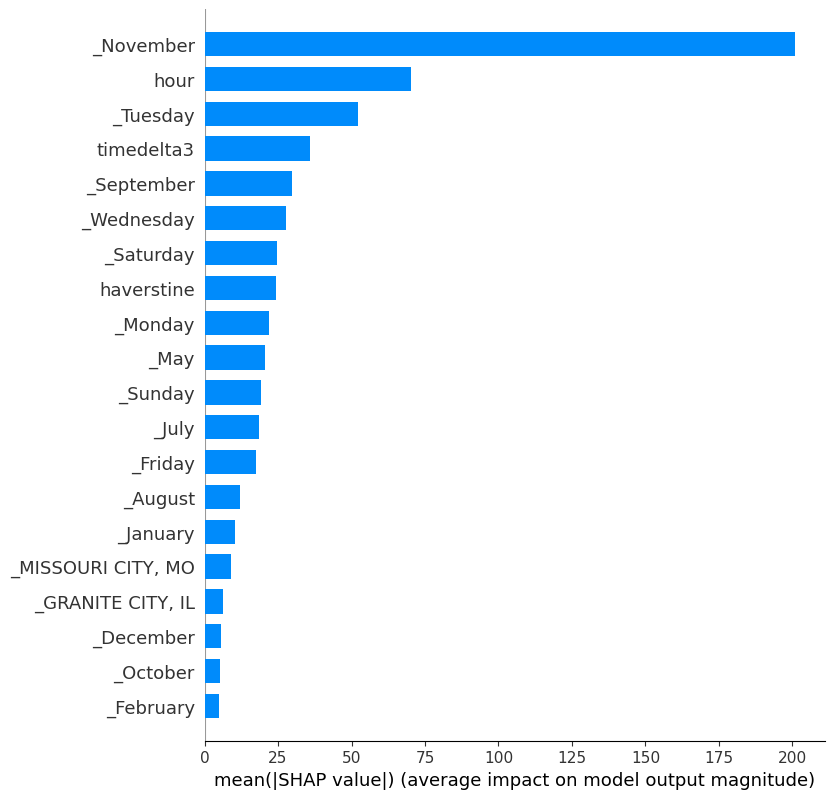

In [37]:
shap_values = explainer(xgX_test)
shap.summary_plot(shap_values, xgX_test, plot_type="bar")

###  Feature importance with weights

Shapely values give a general overall view of the factors influencing the model. The color depicts the higher values of the feature. The points on the plot is representaion of each sample used in the test dataset, the plots reveal the influence each feature had on an individual instance.   

November: We see a good number of points with (November = 1 (red points)) increased arrival times ranging from 200-2000 minutes averagely, While a large number of months that were NOT November (blue points) decreased arrival times at about 200minutes averagely. Model is suggesting train arrival times maybe increased during the month of November.

The hour variable has most of the higher values ie later times in the day increasing the arrival times by lower values like 100 minutes or less, while the lower values in hours like the earlier times in the day or morning decreased arrival times by about 100minuetes averagely. In other words the earlier time the train arrives at the sighting location is higher chances that the arrival time would be faster.

Weekday Tuesday decreases arrival times some points as much as 500minutes while some data points decreases arrival time by about 100-200minutes. The weekday not being tuesday increases the arrival times averagely by 100-200minutes (blue points). 

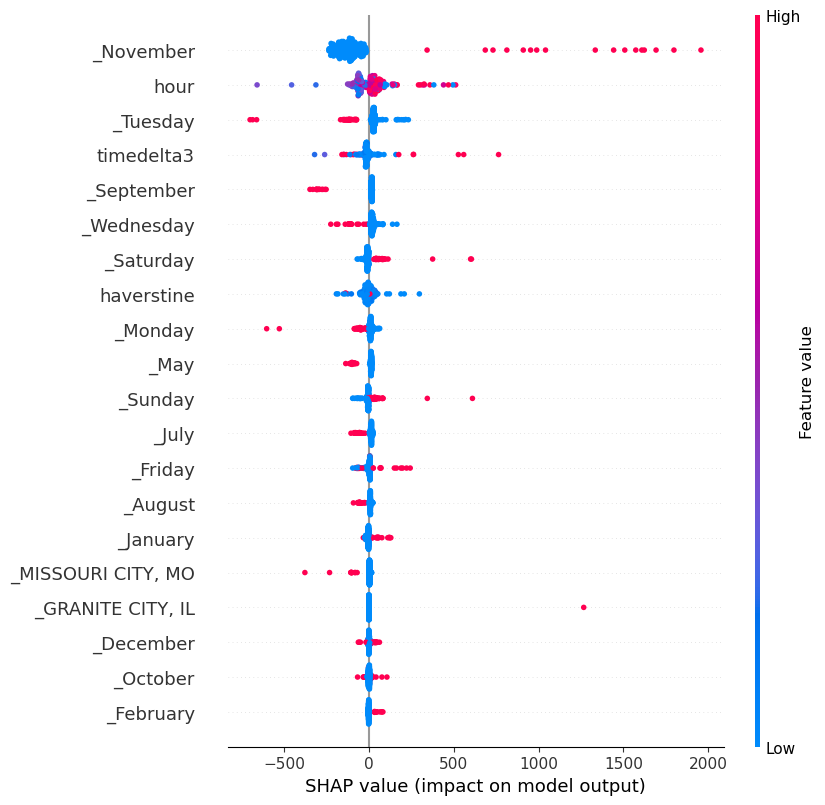

In [38]:
shap.summary_plot(shap_values, xgX_test)

### Data test data set point 6 : Waterfall plot

This is the prediction at row 6 in test dataset here we see the values of the input features:<br>

This plot tells us that the month NOT being November decreased arrival time by 174.12minutes. The day being a Sunday increased arrival time by 77.91minutes, and the sighting location being Salt line city IN decreased arrival times by 32.06minutes. 

Also the base value is 2525minutes that is the average expected time the train arrives over the whole dataset. this data point (or instance) predicted arrival time to be 2437minutes, so this prediction is stating that this train is predicted to arrive earlier than the average train arrival times, this is because the values in blue that are inluencing the reduced arrival times by magnitudes shown below.

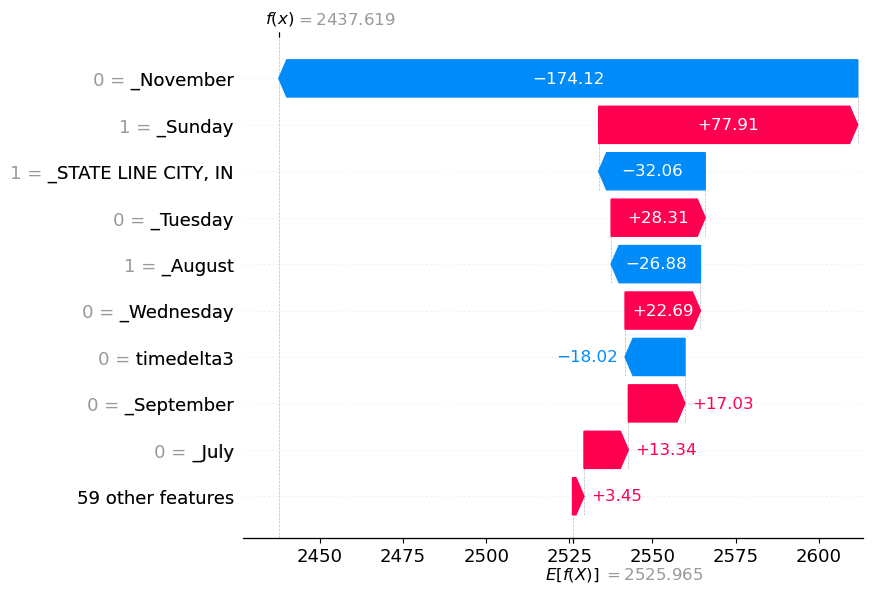

In [39]:
shap.plots.waterfall(shap_values[6])

### Data test data set point 35: Force plot
(plot below) This is another plot that conveys a similar message to the plot read above. as stated earlier the base value for the whole dataset is 2525minutes while the this data point predicts the train will have an arrival time of 2374minutes which is predicting that this train will arrive faster than average arrival time. The main driving force for this was the day being Tuesday which decreases the arrival time by about 150minutes, month being August that decreases the arrival time by about 80 minutes, while the factors that influenced the higher arrival times was the haversine distance at 1027km increases the arrival time about 50minute and the month not being september.

In [41]:
shap.initjs()
shap.force_plot(shap_values[35,:], xgX_test.iloc[35,:])

### SHAP Dependence Contribution Plot

Here we are accessing the relationship between two variables when a variable is specified SHAP automatically plots the varibable that is most correlated to see their dependence on one another. Most of the points that are labelled november have lower timedelta3 that is the time spent at the sight location after arrival. So it seems that during November the train stops at sights are shorter.

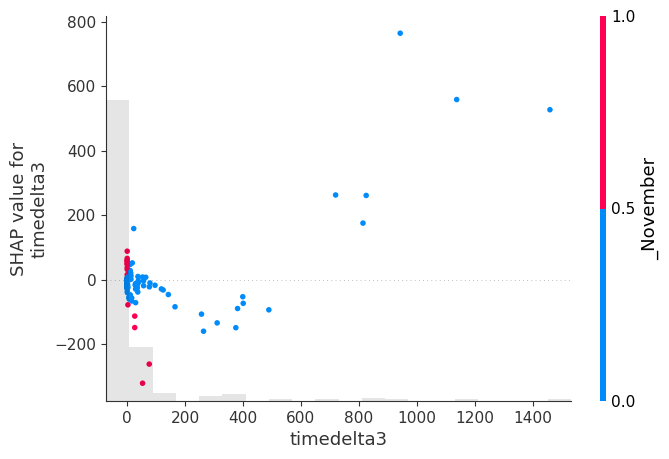

In [44]:
shap.plots.scatter(shap_values[:,"timedelta3"], color=shap_values)

In [45]:
import matplotlib.pyplot as plt
import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

## Summary

The factors that had the most influence on the model were features November, hour of day, weekday Tuesday, timedelta3 (which is the delay period the train spent at each location) and the month of Septmeber. Trips during the month of November increased arrival times from 150 to 1900 minutes averagely and the month not being November decreased arrival times by 200 minutes averagely. Later hours of the day when the train reaches the sighting location increases the arrival time by about 100minutes avaragely while if the train got to aighting location earlier the day that would decrease arrival times by 100minutes averagely. 

There was a correlation between month of November and timedelta3 predictions. When month was not November there are chances the delay time may be a little longer at sighting location.

The model had a RMSE of 1294, which was about half the average arrival time, MAPE mean average percentage error of 27% and negative values for the coefficients of determination. This model does not have acceptable performance. 


## Conclusion

Other alogorithms should be accessed. It is good practice to perform model testing on a variety of algorithms concurrently to compare which algorithm may be a better fit, before hyperparameter tuning. Some other suitable algorithms are Random forest, GLM, Catboost, and a host of others. There are libraries that can streamline and automatically test the data set on many algorithms at once, such as pycaret.

From the R2 metric results the data was inadequate, the sample size was 1610 instances which is small sample size larger sample sizes are needed for good performance, small sample sizes can reduce R2 significantly. The features were not effect in this model performace. Further assessment of the input features and if possible more effective features added to model prediction. 

In [49]:
#conda install graphviz

### Sample portion from one of the decision trees in our model

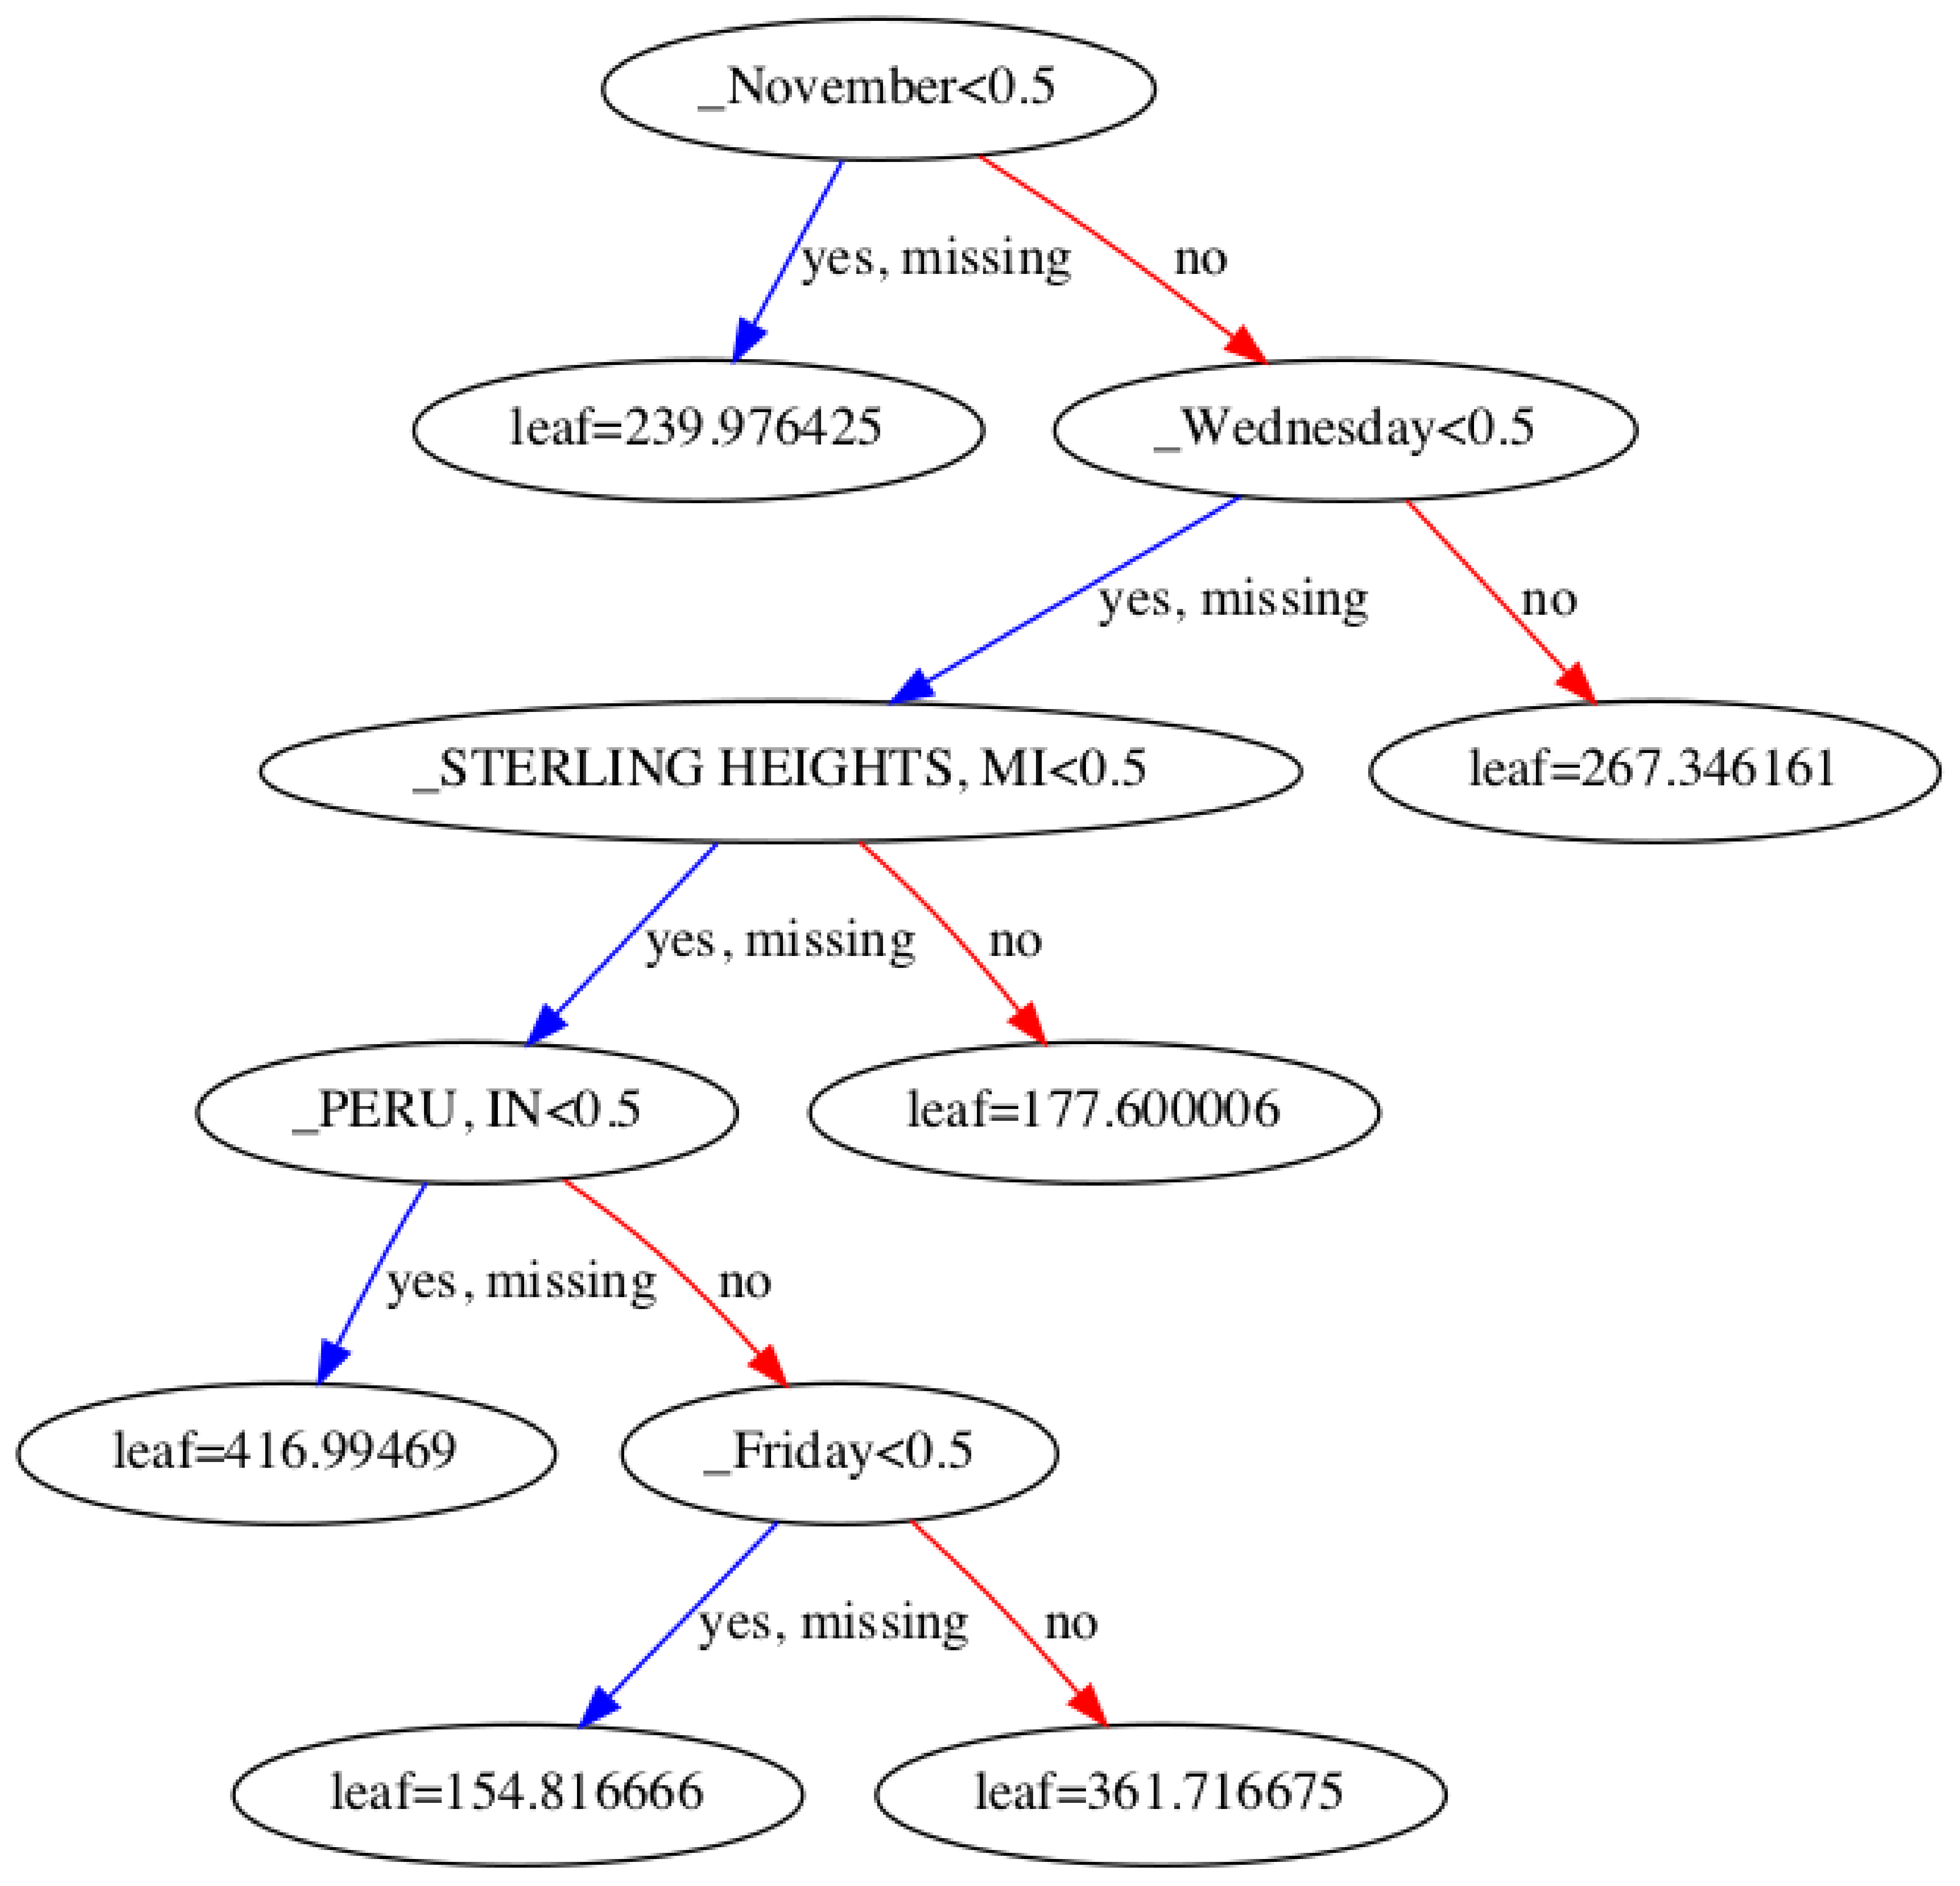

In [51]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [70, 80]
plt.show()

In [62]:
#pip install notebook-as-pdf